In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choices

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [2]:
def read_data(path_to_csv):
    chips_df = pd.read_csv(path_to_csv)
    chips_df['class'] = chips_df['class'].map({'P': 1, 'N': -1})

    X = chips_df.drop('class', axis=1)
    y = chips_df['class']
    return X.to_numpy(), y.to_numpy()

In [3]:
def scatter(X, y, classifier, step):
    X_x, X_y = X[:, 0], X[:, 1]

    points_count = 200
    background_x, background_y = np.meshgrid(
        np.linspace(X_x.min(), X_x.max(), points_count),
        np.linspace(X_y.min(), X_y.max(), points_count)
    )
    background = np.array(list(zip(background_x.ravel(), background_y.ravel())))
    background_pred = classifier.predict(background)

    plt.scatter(background[:, 0], background[:, 1], c=['green' if c == 1 else 'red' for c in background_pred], s=1,
                alpha=0.2)

    plt.scatter(X_x, X_y, c=['green' if c == 1 else 'red' for c in y], s=30)
    plt.title('Step: ' + str(step))
    plt.show()

In [4]:
class AdaBoost:
    def __init__(self):
        self.h = []
        self.a = []

    def fit_one(self, X, y, weights):
        classifier = DecisionTreeClassifier(max_depth=3)
        indices = choices(range(len(X)), weights=weights, k=len(X))
        bootstrap_X = [X[i] for i in indices]
        bootstrap_Y = [y[i] for i in indices]
        classifier.fit(bootstrap_X, bootstrap_Y)

        y_pred = classifier.predict(X)
        error = sum([weights[i] for i in range(len(X)) if y_pred[i] != y[i]])
        alpha = 0.5 * np.log((1 - error) / error) if np.isclose(0, error) else 1

        weights = [weights[i] * np.exp(-alpha * y[i] * y_pred[i]) for i in range(len(weights))]

        z = sum(weights)

        self.h.append(classifier)
        self.a.append(alpha)

        return [w / z for w in weights]

    def fit(self, X, y, steps):
        weights = [1.0 / len(X)] * len(X)
        for i in range(steps):
            weights = self.fit_one(X, y, weights)

    def predict(self, X):
        return np.sign(sum([self.a[i] * self.h[i].predict(X) for i in range(len(self.h))]))

In [5]:
def cross_validate(X, y, steps=100, k=5):
    X_train, X_test, y_train, y_test = [], [], [], []

    k_fold = KFold(n_splits=k)
    for train_indices, test_indices in k_fold.split(X):
        X_train.append(X[train_indices])
        X_test.append(X[test_indices])
        y_train.append(y[train_indices])
        y_test.append(y[test_indices])

    weights = [[1.0 / len(X_train[i])] * len(X_train[i]) for i in range(k)]
    boosters = [AdaBoost() for _ in range(k)]
    scores = []

    for i in range(steps):
        y_pred_test, y_true_test = [], []
        for i in range(k):
            weights[i] = boosters[i].fit_one(X_train[i], y_train[i], weights[i])
            y_pred_test.extend(boosters[i].predict(X_test[i]))
            y_true_test.extend(y_test[i])

        scores.append(f1_score(y_true_test, y_pred_test, average='micro'))

    return scores

### Chips dataset

In [6]:
X, y = read_data('./dataset/chips.csv')

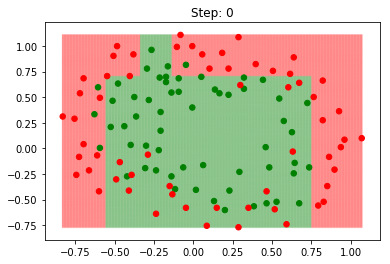

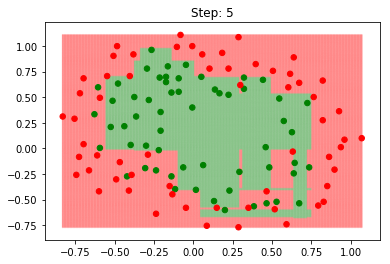

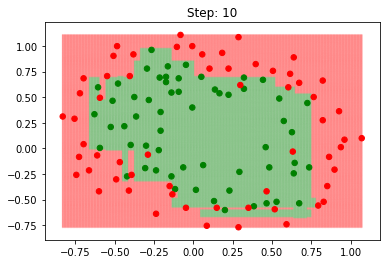

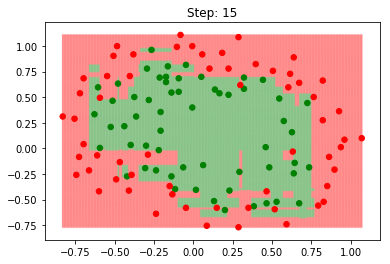

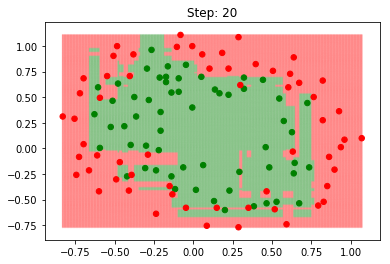

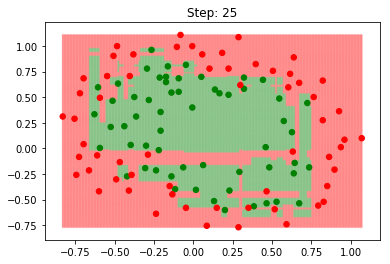

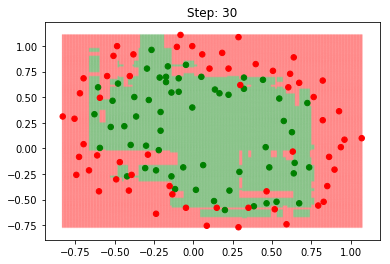

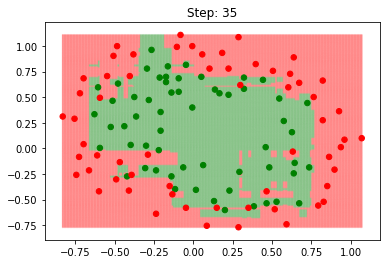

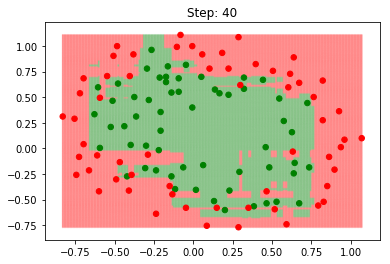

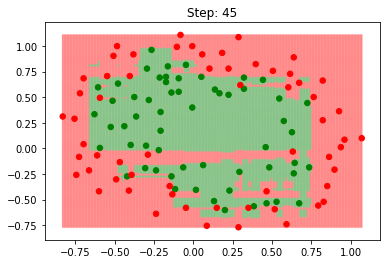

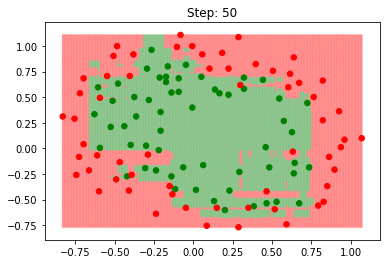

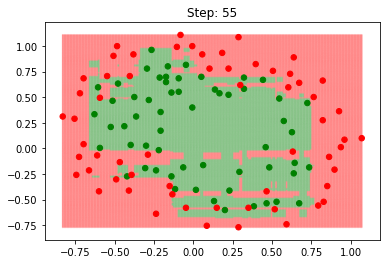

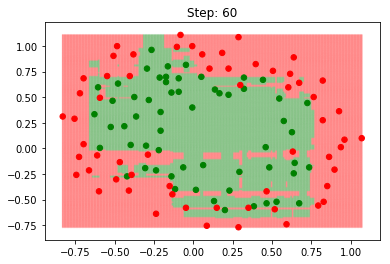

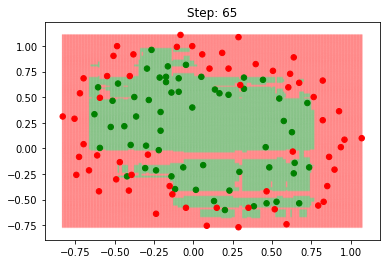

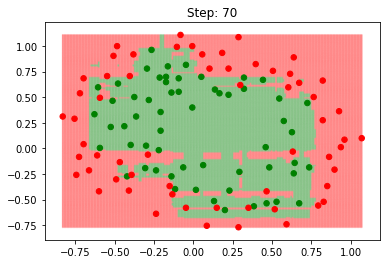

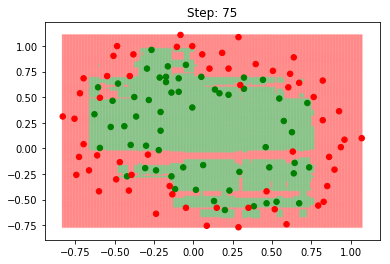

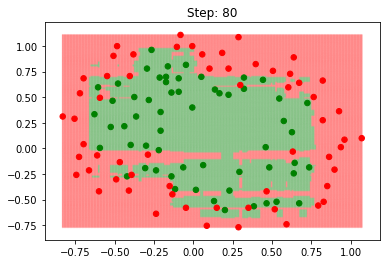

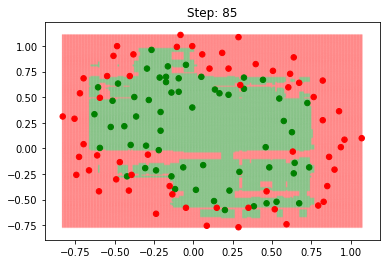

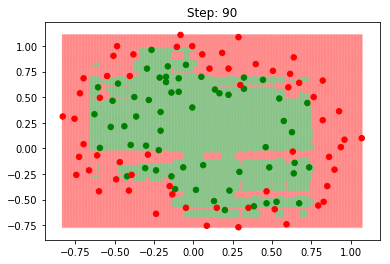

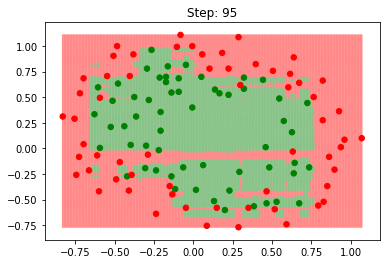

In [7]:
weights = [1.0 / len(X)] * len(X)
steps = 100
booster = AdaBoost()
for step in range(0, steps):
    weights = booster.fit_one(X, y, weights)
    if step % 5 == 0:
        scatter(X, y, booster, step)

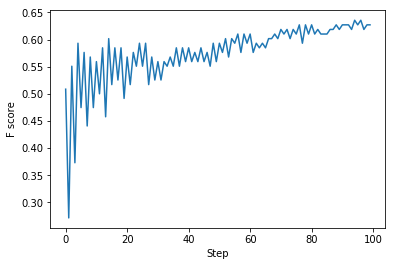

In [8]:
scores = cross_validate(X, y, steps=steps, k=5)

plt.plot(range(0, steps), scores)
plt.xlabel('Step')
plt.ylabel('F score')
plt.show()

### Geyser dataset

In [9]:
X, y = read_data('./dataset/geyser.csv')

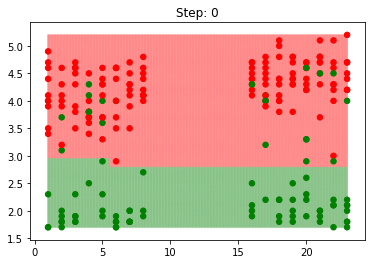

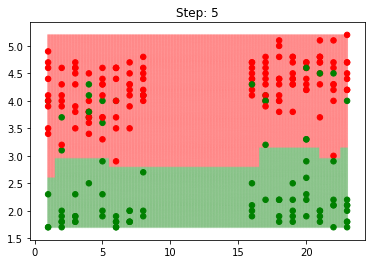

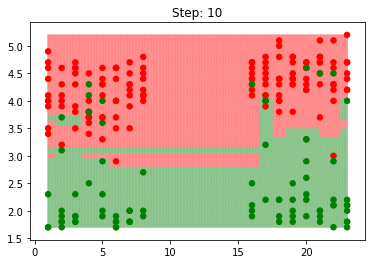

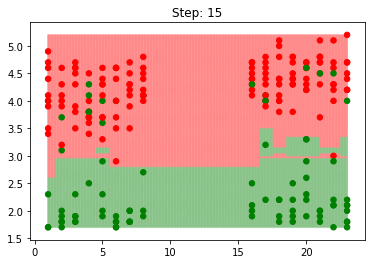

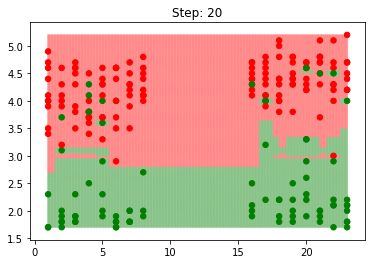

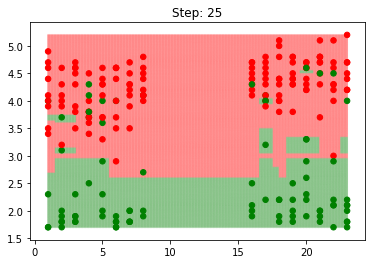

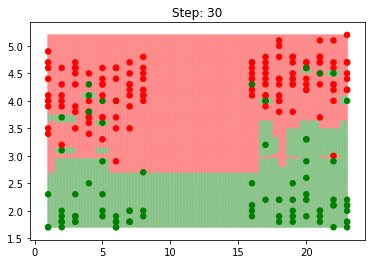

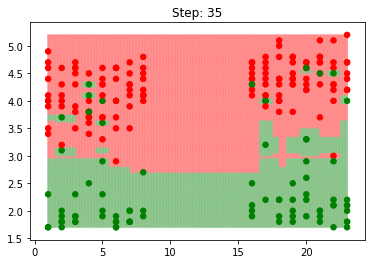

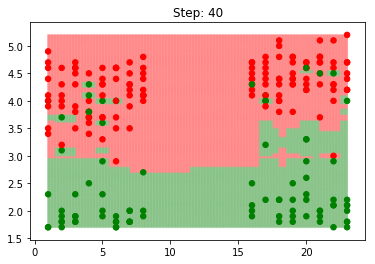

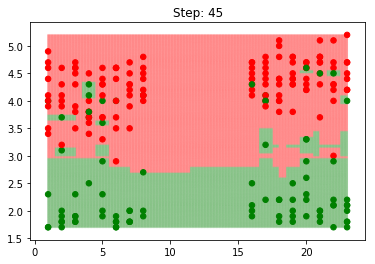

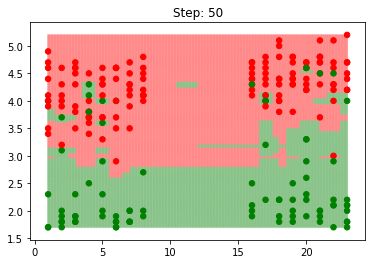

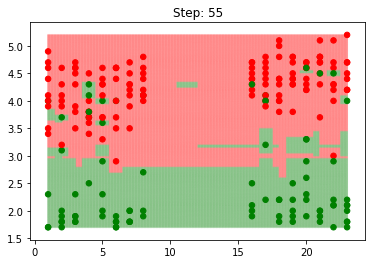

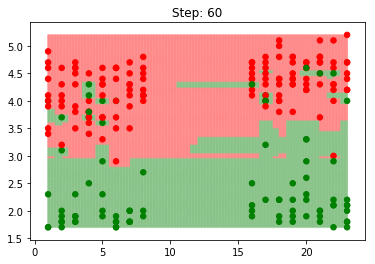

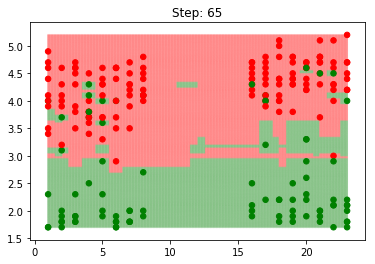

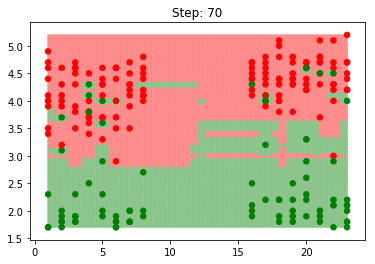

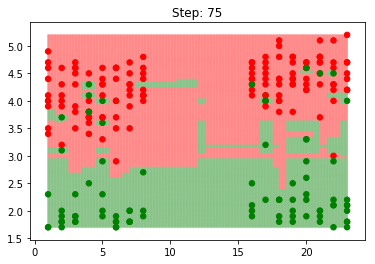

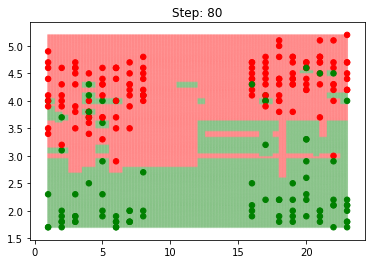

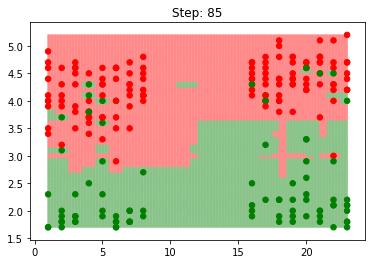

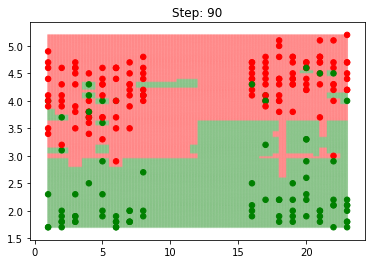

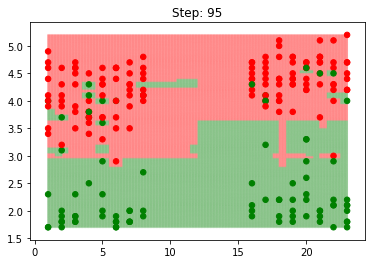

In [10]:
weights = [1.0 / len(X)] * len(X)
steps = 100
booster = AdaBoost()
for step in range(0, steps):
    weights = booster.fit_one(X, y, weights)
    if step % 5 == 0:
        scatter(X, y, booster, step)

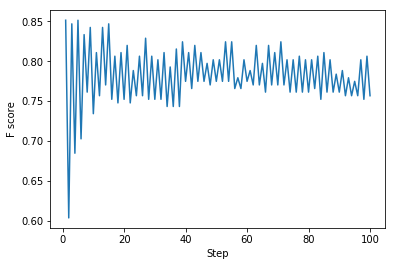

In [11]:
scores = cross_validate(X, y, steps=steps, k=5)

plt.plot(range(1, steps + 1), scores)
plt.xlabel('Step')
plt.ylabel('F score')
plt.show()